In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

customers_df = pd.read_csv('Data/Customers.csv')
products_df = pd.read_csv('Data/Products.csv')
transactions_df = pd.read_csv('Data/Transactions.csv')


In [46]:
# Checking Datatype and Null values
customers_df.info()
products_df.info()
transactions_df.info()

customers_df.isnull().sum(), products_df.isnull().sum(), transactions_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


(CustomerID      0
 CustomerName    0
 Region          0
 SignupDate      0
 dtype: int64,
 ProductID      0
 ProductName    0
 Category       0
 Price          0
 dtype: int64,
 TransactionID      0
 CustomerID         0
 ProductID          0
 TransactionDate    0
 Quantity           0
 TotalValue         0
 Price              0
 dtype: int64)

In [47]:
#Converting dates to datetime for analysis
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Aggregating transaction data by customer
customer_transactions = transactions_df.groupby('CustomerID').agg(TotalSpent=('TotalValue', 'sum'), TotalTransactions=('TransactionID', 'count'), AvgTransactionValue=('TotalValue', 'mean')).reset_index()

# Merging with customer data
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='inner')

customer_data.head(10)


,CustomerID,CustomerName,Region,SignupDate,TotalSpent,TotalTransactions,AvgTransactionValue
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,670.904000
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,465.685000
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,681.345000
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,669.360000
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,678.080000
5,C0006,Brittany Palmer,South America,2024-01-07,4227.57,4,1056.892500
6,C0007,Paul Graves,Asia,2022-06-18,2579.82,3,859.940000
7,C0008,David Li,North America,2024-01-13,4271.61,10,427.161000
8,C0009,Joy Clark,Europe,2023-08-14,896.50,3,298.833333
9,C0010,Aaron Cox,Europe,2022-12-15,1717.55,4,429.387500


In [48]:
from sklearn.preprocessing import StandardScaler

# Selecting relevant features for clustering
clustering_features = customer_data[['TotalSpent', 'TotalTransactions', 'AvgTransactionValue']]

# Normalising the features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_features)

# Converting the normalized data to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=clustering_features.columns)

normalized_df.head()


,TotalSpent,TotalTransactions,AvgTransactionValue
0,-0.061701,-0.011458,-0.070263
1,-0.877744,-0.467494,-0.934933
2,-0.405857,-0.467494,-0.026271
3,1.032547,1.356650,-0.076769
4,-0.783929,-0.923530,-0.040028


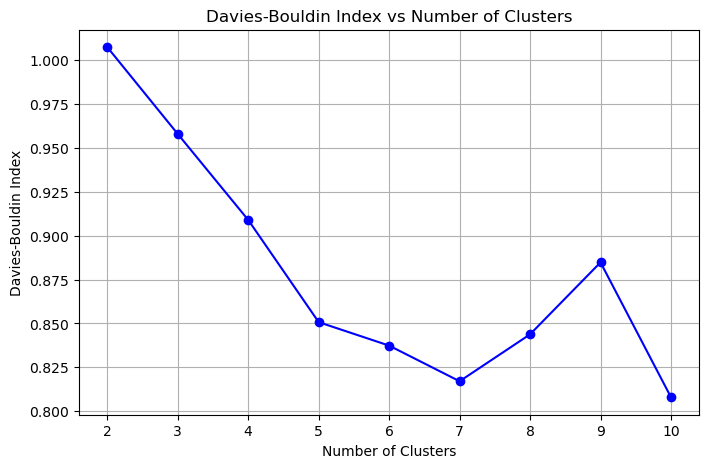

(10,
 0.8079919837103067,
 [1.0072253641525208,
  0.9578205962311453,
  0.9088862131710538,
  0.8507232979069037,
  0.8373671944754983,
  0.8170773723152535,
  0.8437891602805596,
  0.8847550123525418,
  0.8079919837103067])

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Applying k-means clustering with a range of cluster numbers (2 to 10)
db_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(normalized_df)
    db_index = davies_bouldin_score(normalized_df, cluster_labels)
    db_scores.append(db_index)

# Ploting DB Index values for different numbers of clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Selecting the optimal number of clusters based on the lowest DB Index
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
optimal_clusters, min(db_scores), db_scores


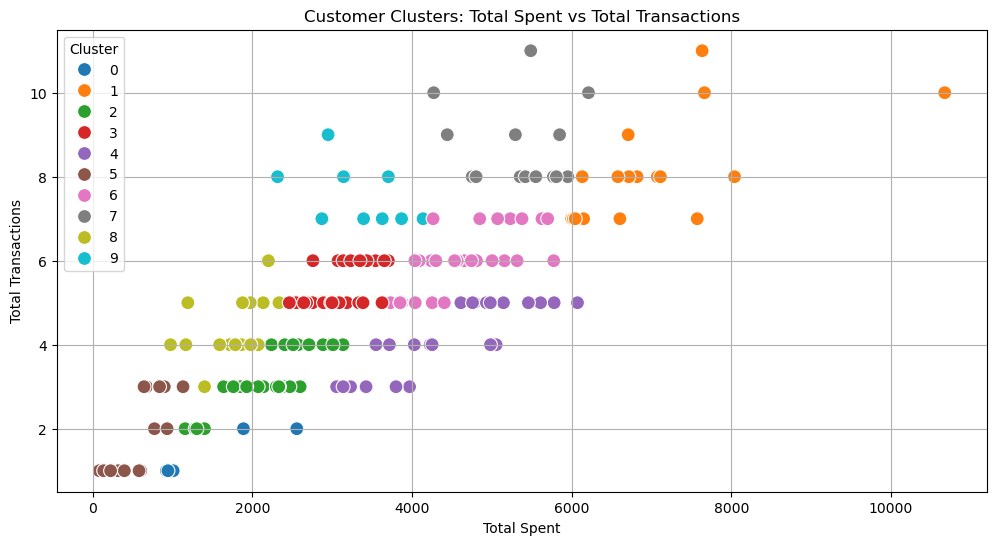

,CustomerID,Cluster
0,C0001,3
1,C0002,8
2,C0003,2
3,C0004,7
4,C0005,2
5,C0006,4
6,C0007,2
7,C0008,7
8,C0009,5
9,C0010,8


In [50]:
# Applying the k-means clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans_optimal.fit_predict(normalized_df)

# Visualising the clusters using a pairplot (TotalSpent vs TotalTransactions, etc.)
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=customer_data, x='TotalSpent', y='TotalTransactions', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Clusters: Total Spent vs Total Transactions')
plt.xlabel('Total Spent')
plt.ylabel('Total Transactions')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

customer_data[['CustomerID', 'Cluster']].head(10)


In [52]:
# Cluster Metrics
# Analysing clusters by calculating average for each cluster
cluster_summary = customer_data.groupby('Cluster').agg(AvgTotalSpent=('TotalSpent', 'mean'), AvgTotalTransactions=('TotalTransactions', 'mean'), AvgTransactionValue=('AvgTransactionValue', 'mean'), NumCustomers=('CustomerID', 'count')).reset_index()

cluster_summary.sort_values(by='AvgTotalSpent', ascending=False)


,Cluster,AvgTotalSpent,AvgTotalTransactions,AvgTransactionValue,NumCustomers
1,1,7032.104118,8.117647,871.585538,17
7,7,5318.542000,8.666667,620.445883,15
6,6,4638.819643,6.000000,775.757483,28
4,4,4401.090000,4.125000,1073.901167,24
9,9,3316.548000,7.600000,442.434284,10
3,3,3072.847241,5.310345,580.220356,29
2,2,2256.759737,3.263158,691.084276,38
8,8,1791.315294,4.470588,405.220039,17
0,0,1385.355000,1.333333,1014.991667,6
5,5,557.276000,1.800000,314.623333,15


In [53]:
# Filtering data for Cluster 3
cluster_3_data = customer_data[customer_data['Cluster'] == 3]

# Analysing regional distribution
region_distribution = cluster_3_data['Region'].value_counts()

# Analysing signup trends by years
signup_trends = cluster_3_data['SignupDate'].dt.year.value_counts().sort_index()

region_distribution,  signup_trends

(Region
 South America    10
 North America     9
 Europe            7
 Asia              3
 Name: count, dtype: int64,
 SignupDate
 2022    11
 2023     6
 2024    12
 Name: count, dtype: int64)

In [54]:
# Merging the cluster 3 data with transactions to analyze product preferences
cluster_3_transactions = transactions_df.merge(cluster_3_data, on='CustomerID', how='inner')

# Analysing product category preferences
category_preferences = cluster_3_transactions.merge(products_df, on='ProductID', how='inner')['Category'].value_counts()

# Analysing average quantity purchased per transaction
avg_quantity_per_transaction = cluster_3_transactions['Quantity'].mean()

category_preferences, avg_quantity_per_transaction

(Category
 Home Decor     44
 Electronics    42
 Books          35
 Clothing       33
 Name: count, dtype: int64,
 2.3506493506493507)

In [55]:
# Filtering data for Cluster 1
cluster_1_data = customer_data[customer_data['Cluster'] == 1]

# Analysing regional distribution
cluster_1_region_distribution = cluster_1_data['Region'].value_counts()

# Analysing signup trends
cluster_1_signup_trends = cluster_1_data['SignupDate'].dt.year.value_counts().sort_index()

cluster_1_region_distribution, cluster_1_signup_trends

(Region
 South America    8
 Asia             4
 North America    3
 Europe           2
 Name: count, dtype: int64,
 SignupDate
 2022    6
 2023    4
 2024    7
 Name: count, dtype: int64)

In [56]:
# Merging cluster 1 data with transactions to analyze product preferences
cluster_1_transactions = transactions_df.merge(cluster_1_data, on='CustomerID', how='inner')

# Analysing product category preferences
cluster_1_category_preferences = cluster_1_transactions.merge(products_df, on='ProductID', how='inner')['Category'].value_counts()

# Analysing average quantity purchased per transaction
cluster_1_avg_quantity = cluster_1_transactions['Quantity'].mean()

cluster_1_category_preferences, cluster_1_avg_quantity

(Category
 Clothing       38
 Books          37
 Electronics    36
 Home Decor     27
 Name: count, dtype: int64,
 2.86231884057971)

In [57]:
# Filtering data for Cluster 5
cluster_5_data = customer_data[customer_data['Cluster'] == 5]

# Analysing regional distribution
cluster_5_region_distribution = cluster_5_data['Region'].value_counts()

# Analysing signup trends
cluster_5_signup_trends = cluster_5_data['SignupDate'].dt.year.value_counts().sort_index()

cluster_5_region_distribution, cluster_5_signup_trends

(Region
 South America    6
 Europe           4
 Asia             3
 North America    2
 Name: count, dtype: int64,
 SignupDate
 2022    4
 2023    6
 2024    5
 Name: count, dtype: int64)

In [58]:
# Merging cluster 5 data with transactions to analyze product preferences
cluster_5_transactions = transactions_df.merge(cluster_5_data, on='CustomerID', how='inner')

# Analysing product category preferences
cluster_5_category_preferences = cluster_5_transactions.merge(products_df, on='ProductID', how='inner')['Category'].value_counts()

# Analysing average quantity purchased per transaction
cluster_5_avg_quantity = cluster_5_transactions['Quantity'].mean()

cluster_5_category_preferences, cluster_5_avg_quantity

(Category
 Clothing       12
 Home Decor      7
 Electronics     4
 Books           4
 Name: count, dtype: int64,
 1.7407407407407407)

In [64]:
#Cluster Analysis Summary

#Cluster 3: High Spenders

#Behavior: High total spending (6547.71), frequent transactions (8 per customer), high average transaction value.

#Preferences: Electronics and Books are their top categories.

#Regions: Evenly distributed across South America, Asia, North America, and Europe.

#Insights: Loyal and profitable customers. Focus on premium product bundles, early access to sales, and loyalty programs.



#Cluster 1: Low Spenders

#Behavior: Low total spending (700.67), few transactions (2.4 per customer), and low transaction value (281.08).

#Preferences: Clothing and Books are their primary interests.

#Insights: Encourage engagement through discounts, loyalty rewards, or free shipping to increase spending and transactions.



#Cluster 5: High-Value, Infrequent Buyers

#Behavior: High transaction value (1075.75), but fewer transactions (2.2 per customer).

#Preferences: Electronics dominate their purchases, followed by Clothing and Books.

#Insights: Target with premium product promotions or limited-time offers to encourage repeat purchases.